# ARIMA Model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

In [3]:
df = pd.read_csv('../data/raw/historical_rental_price_by_suburb.csv')
df = df[df['Name'] != 'Group Total']

In [4]:
# convert data to long data
df_long = df.melt(id_vars=['Name'], 
                  value_vars=[str(year) for year in range(2000, 2024)], 
                  var_name='Year', 
                  value_name='Price')

df_long.loc[(df_long['Name'] == 'Docklands') & (df_long['Year'] == '2001'), 'Price'] = 85
df_long.head()

,Name,Year,Price
0,Albert Park-Middle Park-West St Kilda,2000,266.25
1,Armadale,2000,203.75
2,Carlton North,2000,263.75
3,Carlton-Parkville,2000,260.00
4,CBD-St Kilda Rd,2000,320.00


## Displays Time Series, ACF, and PACF Plots for ARIMA Model

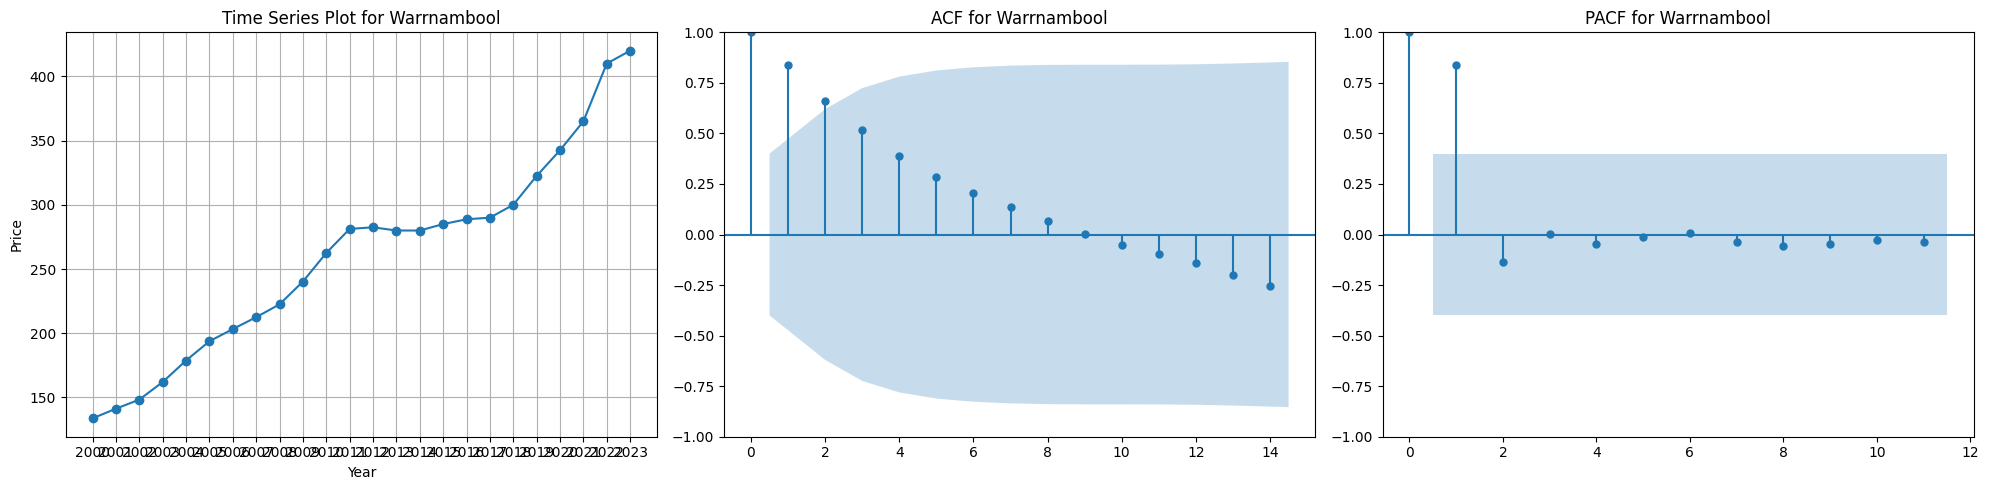

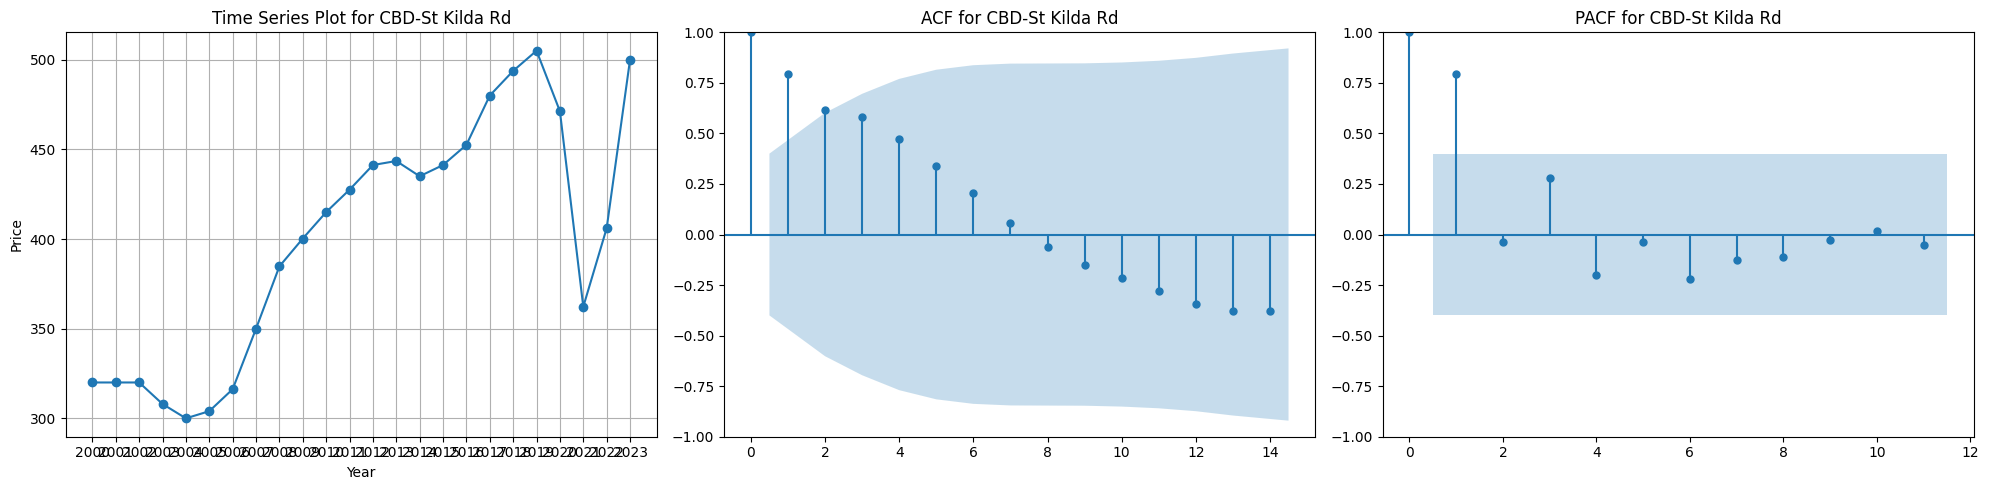

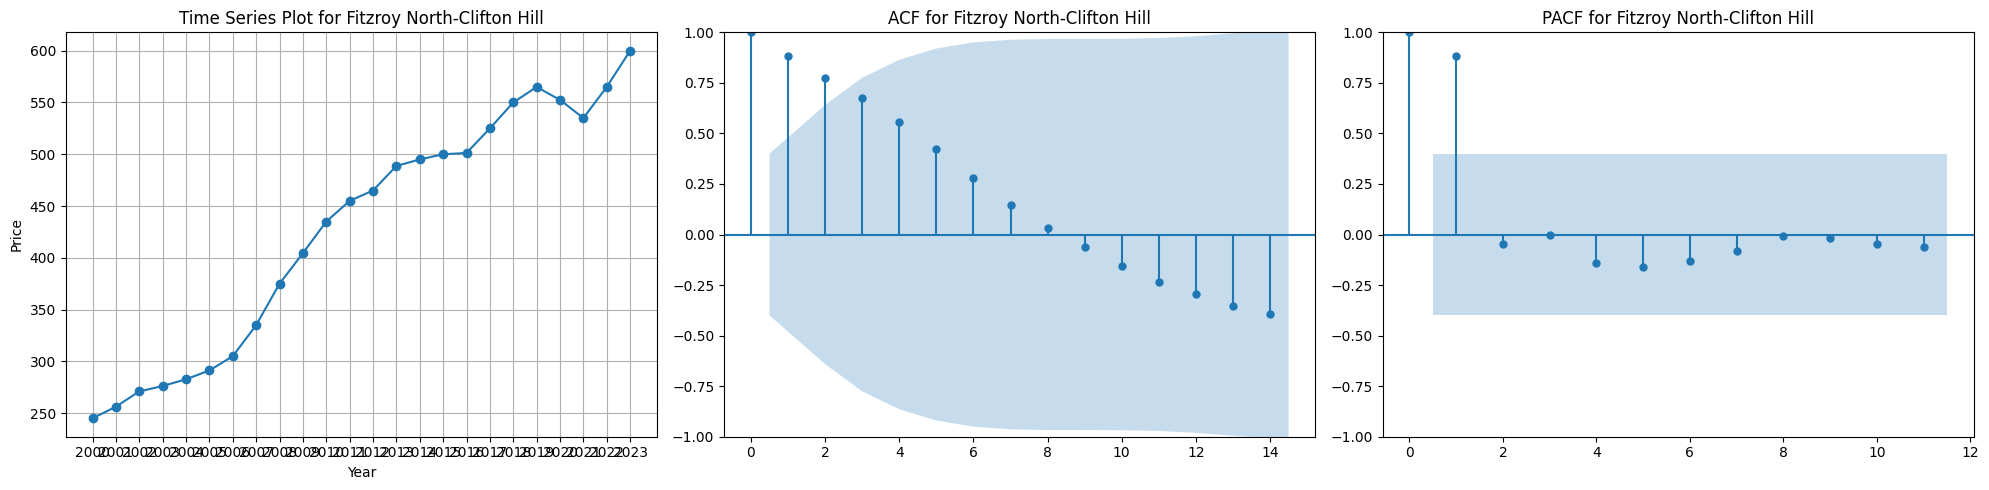

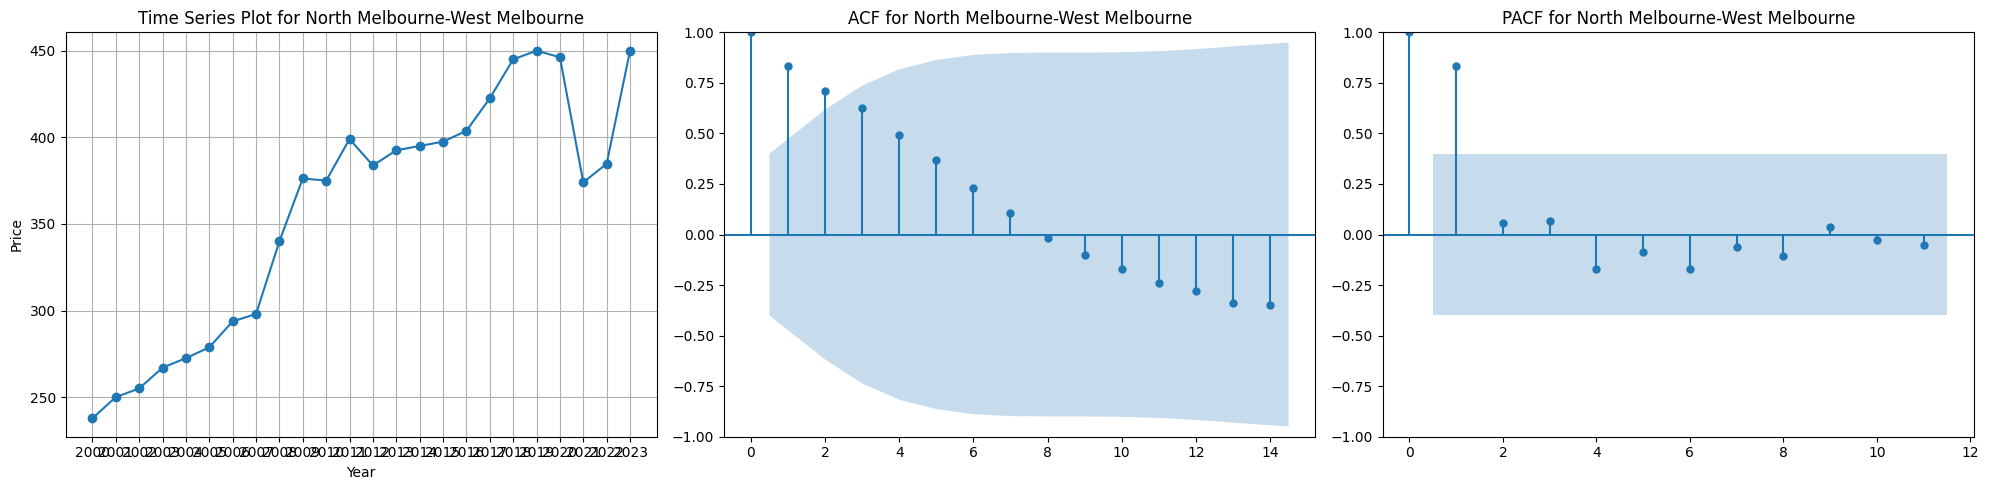

In [5]:
# List of suburbs for which time series and autocorrelation plots will be generated
suburbs = ['Warrnambool', 'CBD-St Kilda Rd', 'Fitzroy North-Clifton Hill', 'North Melbourne-West Melbourne']

for suburb_name in suburbs:
    # Filter the DataFrame to get data for the current suburb and sort it by year
    df_suburb = df_long[df_long['Name'] == suburb_name].sort_values(by='Year')

    # Create a new figure for plotting
    plt.figure(figsize=(20, 5))

    # time series plot
    plt.subplot(1, 3, 1)
    plt.plot(df_suburb['Year'], df_suburb['Price'], marker='o')
    plt.title(f"Time Series Plot for {suburb_name}")
    plt.xlabel('Year')
    plt.ylabel('Price')
    plt.grid(True)

    # ACF
    plt.subplot(1, 3, 2)
    plot_acf(df_suburb['Price'], ax=plt.gca(), title=f"ACF for {suburb_name}")

    # PACF
    plt.subplot(1, 3, 3)
    max_lags = len(df_suburb['Price']) // 2 - 1 
    plot_pacf(df_suburb['Price'], lags=max_lags, ax=plt.gca(), title=f"PACF for {suburb_name}")

    plt.tight_layout()
    
    # Save each figure with the name "time + suburb name"
    plt.savefig(f"../plots/time_{suburb_name.replace(' ', '_')}.png")  # Use '_' instead of spaces in filenames
    plt.show()

## Perform Time Series Forecasting

In [5]:
# Ensure the 'Year' column is of integer data type
df_long['Year'] = df_long['Year'].astype(int)

# Empty dataframe
predictions = pd.DataFrame(columns=['Name', 'Year', 'Predicted_Price'])

# Choose parameter for every suburb by auto_arima
for suburb in df_long['Name'].unique():
    df_suburb = df_long[df_long['Name'] == suburb].sort_values(by='Year')
    
    auto_model = pm.auto_arima(df_suburb['Price'], start_p=1, start_q=1, start_d=0,
                               max_p=8, max_q=4, max_d=5, seasonal=False, stepwise=False,
                               suppress_warnings=True, 
                               error_action="ignore", 
                               trace=False, 
                               scoring='mse')
    
    # Create model
    order = auto_model.order
    model = ARIMA(df_suburb['Price'], order=order)
    model_fit = model.fit()
    
    # Change forecast from 5 steps to 3 steps
    forecast = model_fit.forecast(steps=3)
    
    # Add result to predictions
    future_years = [df_suburb['Year'].max() + i for i in range(1, 4)]  # Changed to 3 steps
    pred_df = pd.DataFrame({
        'Name': [suburb]*3,  # Changed to 3 steps
        'Year': future_years,
        'Predicted_Price': forecast
    })
    predictions = pd.concat([predictions, pred_df])

predictions.reset_index(drop=True, inplace=True)
predictions


/Users/qulingxiao/anaconda3/envs/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/qulingxiao/anaconda3/envs/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/qulingxiao/anaconda3/envs/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/qulingxiao/anaconda3/envs/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/qulingxiao/anaconda3/envs/myenv/lib/python3.8

,Name,Year,Predicted_Price
0,Albert Park-Middle Park-West St Kilda,2024,545.000000
1,Albert Park-Middle Park-West St Kilda,2025,545.000000
2,Albert Park-Middle Park-West St Kilda,2026,545.000000
3,Armadale,2024,503.285802
4,Armadale,2025,512.294302
...,...,...,...
433,Warrnambool,2025,405.897814
434,Warrnambool,2026,405.897814
435,Wodonga,2024,422.097143
436,Wodonga,2025,431.853202


# Calculate the TOP 10 Growth Rates

In [6]:
def get_growth_rate(predictions, df_long, column_name, area):

    """
    Returns the top 10 growth rates between 2023 and 2026 based on the predictions.

    Parameters:
    - predictions: Predicted data.
    - df_long: Original data.
    - column_name: The name of the column in the predictions containing price data.
    - area: The column name representing the geographic area or region.

    Returns:
    - top_10: DataFrame containing the top 10 growth rates.
    """

    # Rename the column in predictions for consistency
    predictions_df = pd.DataFrame(predictions)
    predictions_df = predictions_df.rename(columns={column_name: 'Price'})
    predictions_df = pd.concat([df_long, predictions_df], ignore_index=True)

    # Filter data for the years 2023 and 2026
    df_2023 = predictions_df[predictions_df['Year'] == 2023].reset_index(drop=True)
    df_2026 = predictions_df[predictions_df['Year'] == 2026].reset_index(drop=True)

    # Calculate the growth rate from 2023 to 2026
    df_2023['Growth_Rate'] = (df_2026['Price'] - df_2023['Price']) / df_2023['Price'] * 100

    # Merge the growth rates back into the predictions DataFrame
    predictions_df = predictions_df.merge(df_2023[[area, 'Growth_Rate']], on=area, how='left')

    return predictions_df

In [7]:
predictions_df = get_growth_rate(predictions, df_long, 'Predicted_Price', 'Name')
predictions_df.head()

,Name,Year,Price,Growth_Rate
0,Albert Park-Middle Park-West St Kilda,2000,266.25,0.000000
1,Armadale,2000,203.75,4.884671
2,Carlton North,2000,263.75,0.000000
3,Carlton-Parkville,2000,260.00,1.014648
4,CBD-St Kilda Rd,2000,320.00,-13.397550


## Add Postcode to Prediction

In [8]:
df_suburb = pd.read_csv('../data/raw/suburb_postcode.csv')
df_suburb = df_suburb[['Name', 'postcode']]
df_suburb

,Name,postcode
0,Albert Park,3206
1,Middle Park,3206
2,West St Kilda,3182
3,Armadale,3143
4,Carlton North,3054
...,...,...
223,Wanagaratta,3678
224,Warragul,3820
225,Warrnambool,3280
226,Wodonga,3689


In [9]:
predictions_long = predictions_df.assign(Name=predictions_df['Name'].str.split('-')).explode('Name')

# Merge predictions_long and df_suburb
merged_df = predictions_long.merge(df_suburb, on='Name', how='left')
merged_df.head()

,Name,Year,Price,Growth_Rate,postcode
0,Albert Park,2000,266.25,0.000000,3206
1,Middle Park,2000,266.25,0.000000,3206
2,West St Kilda,2000,266.25,0.000000,3182
3,Armadale,2000,203.75,4.884671,3143
4,Carlton North,2000,263.75,0.000000,3054


## Calculate the Postcodes with the Highest Growth Rates in 2026

In [14]:
avg_price_by_year_postcode = merged_df.groupby(['Year', 'postcode'])['Price', 'Growth_Rate'].mean().reset_index()

avg_price_by_year_postcode = avg_price_by_year_postcode[avg_price_by_year_postcode['Year'] == 2026]

gr_postcode = avg_price_by_year_postcode[['postcode', 'Growth_Rate']]

sorted_gr = gr_postcode.sort_values(by='Growth_Rate', ascending=False)
sorted_gr = sorted_gr[['postcode', 'Growth_Rate']]
sorted_gr.to_csv('../data/curated/ARIMA_growth_rate.csv', index=False)
sorted_gr.head()

/var/folders/lk/6744k3q17_v2x9wj26f14d780000gn/T/ipykernel_85785/1412654047.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  avg_price_by_year_postcode = merged_df.groupby(['Year', 'postcode'])['Price', 'Growth_Rate'].mean().reset_index()


,postcode,Growth_Rate
5178,3630,24.339284
5179,3632,24.339284
5195,3825,22.604200
5064,3072,20.554156
5114,3155,18.946911


## Processe Postcode Data

In [20]:
# Create a copy of the sorted_gr DataFrame
data_to_plot = sorted_gr.copy()

# Modify the 'postcode' column by selecting the first element if it's a list with at least one element
data_to_plot['postcode'] = data_to_plot['postcode'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)

# Extract the unique postcodes from the modified 'postcode' column
postcode = data_to_plot['postcode'].to_list()

# Sort the DataFrame by 'Growth_Rate' in descending order
sorted_gr = sorted_gr.sort_values(by='Growth_Rate', ascending=False)

# Select the top 10 records based on the growth rate
top10_data = sorted_gr.head(10)

top10_data

,postcode,Growth_Rate
5178,3630,24.339284
5179,3632,24.339284
5195,3825,22.604200
5064,3072,20.554156
5114,3155,18.946911
5194,3820,18.750000
5176,3564,18.292683
5181,3661,18.270046
5180,3660,18.270046
5183,3672,18.167861


## Draw Time Series Graph

In [27]:
top10_postcode = top10_data['postcode'].tolist()
plot_df = merged_df[merged_df['postcode'].isin(top10_postcode)]

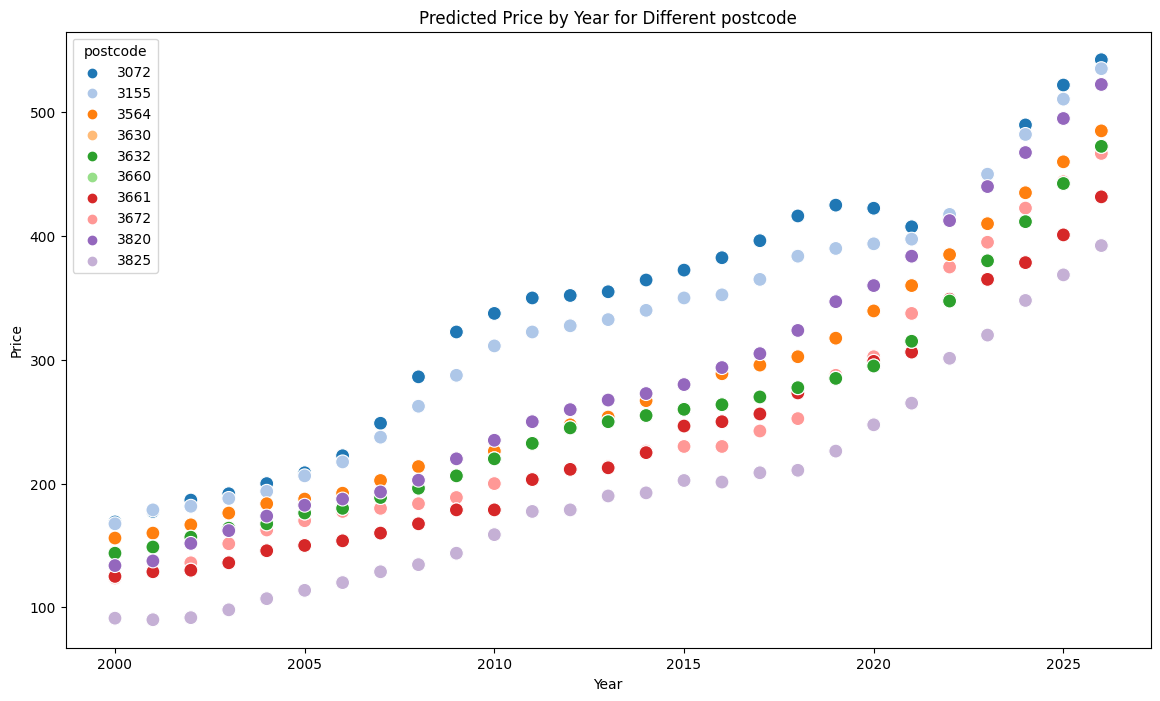

In [26]:
plt.figure(figsize=(14,8))
sns.scatterplot(data=plot_df, x="Year", y="Price", hue="postcode", palette='tab20', s=100, legend=True)
plt.title("Predicted Price by Year for Different postcode")
plt.savefig("../plots/top10.png")
plt.show()